In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Allen-Cahn Phase Field Model: Single Grain Growth

## 개요
본 노트북은 Allen-Cahn 위상장 모델을 이용해 단일 결정(single crystal)의 성장 과정을 시뮬레이션합니다.

## 자유 에너지 함수형식 (Free Energy Functional)

$$F[\phi] = \int \left[ \frac{\varepsilon^2}{2} |\nabla\phi|^2 + \frac{1}{4}(\phi^2 - 1)^2 \right] dx$$

**항의 의미:**
- 첫 번째 항: **그래디언트 에너지(gradient energy)** - 급격한 인터페이스 변화를 억제
- 두 번째 항: **이중 우물 포텐셜(double-well potential)** - $\phi = \pm 1$에서 최솟값을 가짐
- $\phi$: order parameter (질서 매개변수) - 물질의 상(phase)을 나타냄

## Allen-Cahn 시간 진화 방정식

시뮬레이션은 다음 Allen-Cahn 방정식을 기반으로 합니다:

$$\frac{\partial\phi}{\partial t} = -M \frac{\delta F}{\delta \phi} = M\left[\varepsilon^2 \Delta\phi - (\phi^3 - \phi)\right]$$

**매개변수 정의:**
- $M$: **이동성(Mobility)** - 필드 변화 속도를 제어하는 계수
- $\varepsilon^2$: **그래디언트 계수(Gradient Coefficient)** - 인터페이스 폭 제어
- $\Delta$: **라플라시안 연산자(Laplacian Operator)** - 공간 2계 미분

## 초기 조건

$$\phi(x,y,t=0) = \begin{cases}
1 & \text{if } (x-x_c)^2 + (y-y_c)^2 \leq r^2 \\
0 & \text{otherwise}
\end{cases}$$

도메인 중심에 반경 $r$의 원형 영역을 $\phi=1$로 설정하고, 나머지는 $\phi=0$입니다.

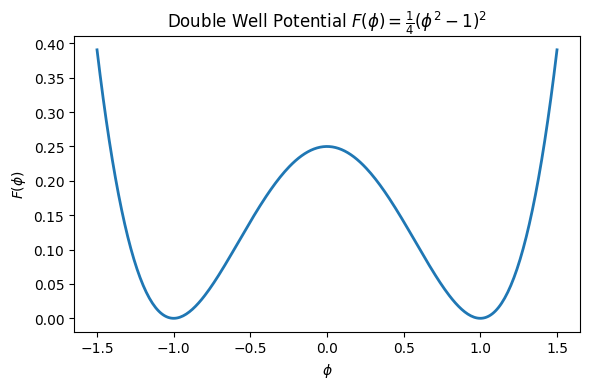

In [18]:
# 이중 우물 포텐셜 함수
def double_well_potential(phi):
    """
    이중 우물 포텐셜 함수

    Parameters
    ----------
    phi : float or np.ndarray
        Order parameter

    Returns
    -------
    float or np.ndarray
        포텐셜 에너지 값
    """
    return 0.25 * (phi**2 - 1)**2

phi_range = np.linspace(-1.5, 1.5, 300)
potentials = double_well_potential(phi_range)

plt.figure(figsize=(6,4))
plt.plot(phi_range, potentials, linewidth=2)
plt.title('Double Well Potential $F(\\phi) = \\frac{1}{4}(\\phi^2 - 1)^2$')
plt.xlabel('$\\phi$')
plt.ylabel('$F(\\phi)$')
plt.tight_layout()
plt.show()

In [13]:
class PhaseFieldSimulation:
    """Phase field model 시뮬레이션 클래스"""

    def __init__(self, N=128, dx=1, dt=0.01, grad_coeff=0.1,
                 mobility=5, radius=5, pbc_x=True, pbc_y=True):
        """
        기초 파라미터 설정 및 시뮬레이션 구조 설정

        Parameters
        ----------
        N : int
            그리드 포인트 개수
        dx : float
            그리드 간격
        dt : float
            시간 스텝
        grad_coeff : float
            그래디언트 계수 (ε²)
        mobility : float
            이동성 (Mobility)
        radius : int
            초기 원형 영역 반경
        pbc_x : bool
            X 방향 주기 경계 조건
        pbc_y : bool
            Y 방향 주기 경계 조건
        """
        self.N = N
        self.dx = dx
        self.dt = dt
        self.grad_coeff = grad_coeff
        self.mobility = mobility
        self.radius = radius
        self.pbc_x = pbc_x
        self.pbc_y = pbc_y

        # 초기화
        self.phi = self._initialize_phi()
        self.step_count = 0

        # 저장된 상태들 (시뮬레이션 진행 중 일정 간격으로 저장)
        self.phi_history = []  # 저장된 phi 필드 리스트
        self.step_history = []  # 저장된 스텝 번호 리스트


    def _initialize_phi(self):
        """
        Order parameter phi 초기화

        Returns
        -------
        np.ndarray
            초기화된 phi 필드 (0으로 초기화, 중심에 반경 radius인 원형 영역을 1로 설정)
        """
        phi = np.zeros((self.N, self.N))
        x = np.arange(self.N)
        y = np.arange(self.N)
        X, Y = np.meshgrid(x, y)
        center = self.N // 2
        mask = (X - center)**2 + (Y - center)**2 <= self.radius**2
        phi[mask] = 1.0
        return phi


    def laplacian(self, phi):
        """
        라플라시안 계산 (Finite Difference Method)
        주기 경계 조건 지원

        Parameters
        ----------
        phi : np.ndarray
            Order parameter 필드

        Returns
        -------
        np.ndarray
            라플라시안 값
        """
        if self.pbc_x:
            phi_xp = np.roll(phi, -1, axis=0)
            phi_xm = np.roll(phi, 1, axis=0)
        else:
            phi_xp = np.zeros_like(phi)
            phi_xm = np.zeros_like(phi)
            phi_xp[:-1, :] = phi[1:, :]
            phi_xm[1:, :] = phi[:-1, :]

        if self.pbc_y:
            phi_yp = np.roll(phi, -1, axis=1)
            phi_ym = np.roll(phi, 1, axis=1)
        else:
            phi_yp = np.zeros_like(phi)
            phi_ym = np.zeros_like(phi)
            phi_yp[:, :-1] = phi[:, 1:]
            phi_ym[:, 1:] = phi[:, :-1]

        return (phi_xp + phi_xm + phi_yp + phi_ym - 4 * phi) / (self.dx * self.dx)


    def update_phi(self):
        """
        Order parameter phi 업데이트 (시간 스텝 한 번)

        Allen-Cahn 방정식: ∂φ/∂t = M[ε²∇²φ - (φ³ - φ)]
        여기서 M은 mobility, ε²는 grad_coeff
        """
        lap = self.laplacian(self.phi)
        self.phi += self.dt * self.mobility * (self.grad_coeff * lap - (self.phi**3 - self.phi))
        self.step_count += 1


    def run_simulation(self, nsteps, save_interval=None):
        """
        시뮬레이션 실행 및 상태 저장

        Parameters
        ----------
        nsteps : int
            시뮬레이션 스텝 수
        save_interval : int or None
            몇 스텝마다 phi를 저장할지. None이면 마지막 상태만 저장
        """
        self.phi_history = [self.phi.copy()]
        self.step_history = [self.step_count]

        for step in range(nsteps):
            self.update_phi()

            if save_interval is not None and self.step_count % save_interval == 0:
                self.phi_history.append(self.phi.copy())
                self.step_history.append(self.step_count)

        if save_interval is None or self.step_count % save_interval != 0:
            self.phi_history.append(self.phi.copy())
            self.step_history.append(self.step_count)


    def visualize_snapshots(self, num_snapshots=5):
        """
        저장된 시뮬레이션 과정을 동일한 크기의 정적 이미지로 표시하고,
        전체 Figure에 대한 공통 colorbar를 생성합니다.
        """
        if not self.phi_history:
            print("Error: No simulation history. Run simulation first.")
            return

        indices = np.linspace(0, len(self.phi_history) - 1, num_snapshots, dtype=int)

        fig, axes = plt.subplots(1, num_snapshots, figsize=(4 * num_snapshots, 4))

        if num_snapshots == 1:
            axes = [axes]

        im = None
        for idx, ax_idx in enumerate(indices):
            ax = axes[idx]
            phi_snap = self.phi_history[ax_idx]
            step_label = self.step_history[ax_idx]

            im = ax.pcolormesh(phi_snap, cmap='RdBu', vmin=-1, vmax=1)
            ax.set_title(f"Step {step_label}", fontsize=12)
            ax.set_aspect('equal')

        # Figure의 오른쪽에 colorbar를 위한 새로운 축(cax)을 직접 추가합니다.
        # [left, bottom, width, height] 값은 figure 전체 크기에 대한 상대적인 비율입니다.
        fig.subplots_adjust(right=0.9) # subplot들이 colorbar와 겹치지 않도록 조정
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # 위치와 크기 조절

        if im is not None:
            fig.colorbar(im, cax=cbar_ax)

        plt.show()


    def visualize_animation(self, output_filename='phase_field_simulation.mp4', fps=10):
        """
        저장된 시뮬레이션을 mp4 animation으로 저장

        Parameters
        ----------
        output_filename : str
            저장할 mp4 파일명
        fps : int
            애니메이션 프레임 속도 (frames per second)
        """
        if not self.phi_history:
            print("Error: No simulation history. Run simulation first with run_simulation().")
            return

        fig, ax = plt.subplots(figsize=(6, 6))

        def animate(frame_idx):
            ax.clear()
            im = ax.pcolormesh(self.phi_history[frame_idx], cmap='RdBu', vmin=-1, vmax=1)
            ax.set_title(f"Time: {self.step_history[frame_idx]} steps")
            ax.set_aspect('equal')
            return [im]

        anim = FuncAnimation(fig, animate, frames=len(self.phi_history),
                           interval=100, blit=False, repeat=True)

        writer = FFMpegWriter(fps=fps)
        anim.save(output_filename, writer=writer)
        plt.close()
        print(f"Animation saved to {output_filename}")

Running simulation and saving states...
Visualizing snapshots...


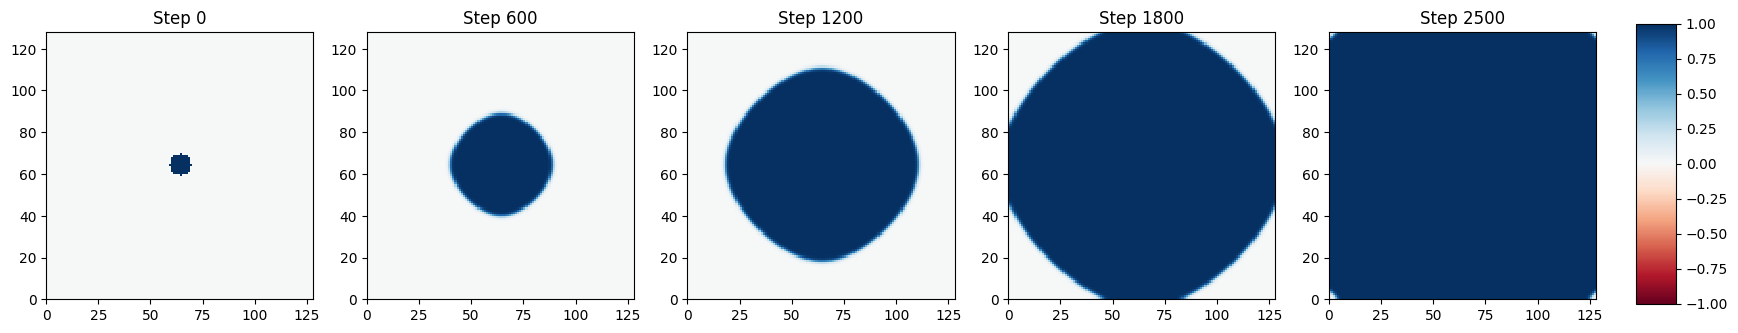

Generating animation...
Animation saved to phase_field.mp4
Total saved states: 26
Simulation steps: [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500]


In [14]:
if __name__ == "__main__":
    sim = PhaseFieldSimulation(
        N=128,
        dx=1,
        dt=0.01,
        grad_coeff=0.1,
        mobility=5,
        radius=5,
        pbc_x=True,
        pbc_y=True
    )

    # 시뮬레이션 실행 (100 스텝마다 저장)
    print("Running simulation and saving states...")
    nsteps = 2500
    sim.run_simulation(nsteps=nsteps, save_interval=100)

    # 방법 1: 스냅샷으로 시각화 (1×5 배열)
    print("Visualizing snapshots...")
    sim.visualize_snapshots(num_snapshots=5)

    # 방법 2: 애니메이션으로 저장 (mp4 형식)
    print("Generating animation...")
    sim.visualize_animation(output_filename='phase_field.mp4', fps=10)

    # 저장된 상태 개수 확인
    print(f"Total saved states: {len(sim.phi_history)}")
    print(f"Simulation steps: {sim.step_history}")

## 수치 계산 방법: Finite Difference Method (유한 차분법)

공간 미분은 유한 차분 방법으로 근사합니다:

$$\Delta\phi_{i,j} \approx \frac{\phi_{i+1,j} + \phi_{i-1,j} + \phi_{i,j+1} + \phi_{i,j-1} - 4\phi_{i,j}}{(\Delta x)^2}$$

여기서 $\Delta x = 1$은 격자 간격입니다.

### 주기 경계 조건 (Periodic Boundary Conditions)

경계 효과를 최소화하기 위해 주기 경계 조건을 적용합니다.
`np.roll()` 함수를 사용하여 격자의 양쪽 끝이 순환적으로 연결됩니다.

## 시간 적분: 명시적 오일러 방법 (Explicit Euler Method)

Allen-Cahn 방정식을 시간에 대해 수치 적분합니다:

$$\phi^{n+1}_{i,j} = \phi^n_{i,j} + \Delta t \cdot M \left[\varepsilon^2 \Delta\phi^n_{i,j} - ((\phi^n_{i,j})^3 - \phi^n_{i,j})\right]$$

**수치 안정성 조건:**

명시적 오일러 방법의 안정성을 위해 시간 스텝은 다음을 만족해야 합니다:

$$\Delta t \lesssim \frac{(\Delta x)^2}{M \cdot \varepsilon^2}$$

본 시뮬레이션에서는 $\Delta t = 0.01$로 충분히 작은 값을 사용합니다.

## 시뮬레이션 파라미터 및 물리적 해석

| 파라미터 | 값 | 물리적 의미 |
|---------|-----|-----------|
| `N` | 128 | 격자 크기 (128×128 점) |
| `dx` | 1.0 | 격자 간격 |
| `dt` | 0.01 | 시간 스텝 |
| `nsteps` | 2500 | 총 시뮬레이션 스텝 |
| `grad_coeff` | 0.1 | 그래디언트 계수 $\varepsilon^2$ |
| `mobility` | 5.0 | 이동성 $M$ |
| `radius` | 5 | 초기 원 반경 |
